# **2. Generation-based-MRC 모델 구성**
- 앞에서 변환한 데이터 세트를 활용할 예정

## **1. GPU 셋팅확인**

In [ ]:
# 구글 드라이브 불러오기
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Setting 할당된 GPU 확인
!nvidia-smi

Sun Dec  1 15:55:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   54C    P8              13W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## **2.관련 패키지 설치 및 준비**

###**transformers, huggingface_hub, protbuf evaluete 설치**

- Huggingface_hub : 통합적으로 사전 학습된 모델을 제공하거나 NLP 작업을 위해 미리 설정된 파이프라인 제공

- Transformer: 사전 학습된 언어 모델을 사용하여 NLP 작업을 할 수 있도록 해줌

- Protobuf: Google에서 개발한 직렬화/역직렬화 포맷

- Evaluate : NLP 모델 성능 평가 지표 (Metric 제공)

In [ ]:
pip install --upgrade transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 102.2 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.46.2
    Uninstalling transformers-4.46.2:
      Successfully uninstalled transformers-4.46.2


In [ ]:
# 필요한 라이브러리
!pip uninstall -y datasets huggingface_hub transformers # 호환성 문제 때문에 삭제 했다가 다시 깜
!pip install datasets transformers huggingface_hub # 최신 버전으로 재설치
!pip install protobuf==3.20.3 # 데이터 직렬화/역직렬화
!pip install evaluate # 평가 metric 제공 지표

Found existing installation: huggingface-hub 0.26.2
Uninstalling huggingface-hub-0.26.2:
  Successfully uninstalled huggingface-hub-0.26.2
Found existing installation: transformers 4.46.3
Uninstalling transformers-4.46.3:
  Successfully uninstalled transformers-4.46.3
  Using cached transformers-4.46.3-py3-none-any.whl.metadata (44 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 33.5 MB/s eta 0:00:00
Using cached transformers-4.46.3-py3-none-any.whl (10.0 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.6/447.6 kB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 9.1 MB/s eta 0:00:00


### **tokenizer, Datasets, metrics 불러오기**

- squad metric는 EM과 F1 score을 기반으로 성능을 평가함
- EM : 예측이 정답과 정확히 일치하는 경우의 비율 (EM=1, EM=0)
- F1-score : 예측과 정답 간의 부분적인 일치를 평가 (Precision과 Recall의 조화 평균)
  - Precision(정밀도): 예측한 단어 중 실제 정답과 일치하는 비율.
  - Recall(재현율): 실제 정답 단어 중 예측에서 맞춘 비율

In [ ]:
# 데이터 가져오기
from datasets import load_dataset
datasets = load_dataset(
    'json',
    data_files={
        'train': '/content/drive/MyDrive/MRC/train.json',  # 구글 드라이브 저장해둔거
        'validation': '/content/drive/MyDrive/MRC/validation.json', # 구글 드라이브에 저장해둔
    }
)

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

In [ ]:
# sentece-tokenizer(문장단위) 다운로드
# NLTK punkt 강제 다운로드 및 경로 확인
import nltk

# 사용자 경로 추가 (Colab 환경)
nltk.data.path.append('/content/nltk_data')

# punkt 리소스 다운로드
nltk.download('punkt', download_dir='/content/nltk_data')

# 다운로드 확인
print("Downloaded punkt resource:")
print(nltk.data.find('tokenizers/punkt'))


# datasets 로딩해오기
print(datasets)

# 평가 metric 불러오기
from evaluate import load
metric=load('squad')

[nltk_data] Downloading package punkt to /content/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Downloaded punkt resource:
/content/nltk_data/tokenizers/punkt
DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 11010
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 1326
    })
})


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## **3. Pretrained 모델 및 tokenizer 불러오기**

In [ ]:
#사전 학습된 모델과 관련 토크나이저, 구성 정보를 효율적으로 로드
from transformers import (
    AutoConfig, # 사전 학습 모델의 구성 정보 로드
    AutoModelForSeq2SeqLM, # Seq2seq에 필요한 모델 로드
    AutoTokenizer #토큰 형태 변환 도구 로드
)

### **모델 객체 생성**
- 모델 구성 정보 저장 (config)
- 모델 전용 tokenizer 가져오기 (tokenizer)
- 모델 자체 가져오기 (model)

In [ ]:
model_name='google/mt5-small' # BART랑 용도는 비슷 , mt5 : 여러가지 언어를 다룰 수 있는 모델

In [ ]:
# mt5-small 모델의 구성 저장
config = AutoConfig.from_pretrained(
    model_name,
    cache_dir=None # 모델 파일을 저장할 캐시 경로 (기본)
)

# mt5-small 모델 전용 tokenizer 가져오기
tokenizer= AutoTokenizer.from_pretrained(
    model_name, #어떤 모델의 토크나이저를 가져올지 지정
    cache_dir=None, # 모델 파일을 저장할 캐시 경로 (기본)
    use_fast=True #빠르고 효율적인 Fast Tokenizer 사용 여부
)

# mt5-small 모델 가져오기
model=AutoModelForSeq2SeqLM.from_pretrained(
    model_name,
    config=config,
    cache_dir=None
)

config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

### **모델 학습을 위한 파라미터 준비 단계**
- max_source_length : 입력 텍스트를 토큰화 후, 입력 토큰의 최대 길이
- max_target_length : 출력 텍스트를 토큰화 후, 출력 토큰의 최대 길이 -> Decoding 단계에서 필요
- padding : 패딩을 사용하여 고정 길이로 맞출지의 여부
- preprocessing_num_workers : 데이터 전처리 시 병렬로 작업한 워커(worker)의 수
- num_beams : Beam Search 탐색 경로의 수
- max_train_samples : 훈련 데이터에서 사용할 샘플의 최대 개수
- max_val_samples : 검증 데이터에서 사용할 샘플의 최대 개수
- num_train_epochs : 전체 훈련 데이터를 몇번 반복해서 학습할지 설정

In [ ]:
max_source_length = 512
max_target_length = 128
padding = False
preprocessing_num_workers = 30
num_beams = 2
max_train_samples = 2000
max_val_samples = 300
num_train_epochs = 3

## **4. 데이터 전처리 단계**

In [ ]:
print(datasets['train'][0])

{'id': 'etri_2604', 'title': '제2차 세계 대전 개요', 'context': '- 히로시마·나가사키 원자폭탄 투하 (1945년 8월 6일, 9일)', 'question': '히로시마 나가사키 원자폭탄 투하가 일어난 것은 언제인가?', 'answers': {'answer_start': [21], 'text': ['1945년']}}


In [ ]:
# 데이터 특징: 동일한 question이 반복해서 등장함
datasets['train']['question']

['히로시마 나가사키 원자폭탄 투하가 일어난 것은 언제인가?',
 '히로시마 나가사키 원자폭탄 투하가 일어난 것은 언제인가?',
 '히로시마 나가사키 원자폭탄 투하가 일어난 것은 언제인가?',
 '히로시마 나가사키 원자폭탄 투하가 일어난 것은 언제인가?',
 '히로시마 나가사키 원자폭탄 투하가 일어난 것은 언제인가?',
 '히로시마 나가사키 원자폭탄 투하가 일어난 것은 언제인가?',
 '히로시마 나가사키 원자폭탄 투하가 일어난 것은 언제인가?',
 '나가사키에 원폭이 투하되고 며칠 후에 일본이 항복을 하였나?',
 '나가사키에 투하된 원자폭탄은 무엇으로 만들어졌는가?',
 '나가사키에 투하된 원자폭탄은 무엇으로 만들어졌는가?',
 '나가사키에 투하된 원자폭탄은 무엇으로 만들어졌는가?',
 '나가사키에 투하된 원자폭탄은 무엇으로 만들어졌는가?',
 '하와이는 1778년에 누가 발견하였나?',
 '하와이는 1778년에 누가 발견하였나?',
 '하와이는 1778년에 누가 발견하였나?',
 '하와이는 1778년에 누가 발견하였나?',
 '하와이는 1778년에 누가 발견하였나?',
 '하와이는 1778년에 누가 발견하였나?',
 'K리그가 처음이 출범한 해는?',
 'K리그가 처음이 출범한 해는?',
 'K리그가 처음이 출범한 해는?',
 'K리그가 처음이 출범한 해는?',
 'K리그가 처음이 출범한 해는?',
 '대한민국 최초의 프로 축구단은?',
 '대한민국 최초의 프로 축구단은?',
 'K리그에서 언제부터 실업축구단을 빼고 프로축구단만 참여하였나?',
 'K리그에서 언제부터 실업축구단을 빼고 프로축구단만 참여하였나?',
 '잉글랜드 프리미어 리그는 언제부터 시작하였나?',
 '잉글랜드 프리미어 리그는 언제부터 시작하였나?',
 '잉글랜드 프리미어 리그는 언제부터 시작하였나?',
 '잉글랜드 프리미어 리그는 언제부터 시작하였나?',
 '잉글랜드 프리미어 리그는 언제부터 시작하였나?',
 '잉글랜드 프리미어 리그는 언제부터 시작하였나?',
 '잉글랜드 프리미어 리그는

In [ ]:
# context의 특징을 보면 question,answer은 같지만 문맥은 다른것으로 보
datasets['train']['context']

['- 히로시마·나가사키 원자폭탄 투하 (1945년 8월 6일, 9일)',
 '- 히로시마·나가사키 원자폭탄 투하, 광복(1945년)',
 '- 히로시마와 나가사키의 원자 폭탄 투하 (1945년)',
 "이렇게 우라늄-235와 플루토늄을 바탕으로 원자폭탄 3개가 완성되었고, 그 중에서 플루토늄 원자폭탄 하나를 이용해 1945년 뉴멕시코주의 앨러모고도에서 폭발실험이 진행되었다. 이것이 세계 최초의 원자폭탄 실험인 '트리니티 실험'이다. 이 실험을 통해 핵무기의 엄청난 위력이 확인되었고, 1945년 8월 6일과 9일 일본의 히로시마와 나가사키에 각각 우라늄 폭탄과 플루토늄 폭탄이 투하됨으로써 제2차세계대전이 막을 내린다.",
 '사사키 데루후미(佐木輝文)는 일본 외과 전문의 출신 前 정치가인데 1945년 일본 히로시마·나가사키 원자폭탄 투하 사태의 직·간접성 관련자이기도 하다.',
 '1944년 11월 이후, 연일 일본으로 출격하는 B-29가 이 섬에서 이륙했다. 1945년, 8월 6일 히로시마에, 8월 9일에는 나가사키에 원자폭탄을 투하하는 B-29도 이곳에서 출격하게 된다.',
 '전쟁이 일본 제국의 패망으로 치닫기 직전이었던 1945년 8월, 히로시마 시와 나가사키 시에 원자폭탄인 리틀보이와 팻 맨이 투하되었을 때 많은 일본인들이 희생되었는데, 히로시마와 나가사키에 군수공장 등에 징용되었던 수많은 조선인들도 이때 같이 희생되었다. 그러나 이때 원자폭탄으로 희생된 조선인들에 대한 보상은 오늘날 일본 정부와 대한민국 정부 양측에서 전혀 이루어지지 않고 있다.',
 '나가사키 원폭투하 6일 후 8월 15일 일본은 연합군에 무조건 항복을 선언했으며, 9월 2일 항복 문서 에 사인하면서 공식적으로 태평양 전쟁과 제2차 세계대전의 종전을 알렸다. 한편 독일은 이미 5월 7일 유럽에서 항복을 선언했다. 이 원폭투하로 인해 전후 일본은 "핵무기를 만들지 않으며, 갖지 않으며, 들여오지 않겠다"는 비핵 3원칙을 수용했다. 이 원자폭탄 투하 사건은 윤리적 문제와 "당시 미국이

In [ ]:
# 당연히 같은 question에 대한 답은 같겠음
datasets['train']['answers']

[{'answer_start': [21], 'text': ['1945년']},
 {'answer_start': [24], 'text': ['1945년']},
 {'answer_start': [24], 'text': ['1945년']},
 {'answer_start': [160], 'text': ['1945년']},
 {'answer_start': [37], 'text': ['1945년']},
 {'answer_start': [45], 'text': ['1945년']},
 {'answer_start': [26], 'text': ['1945년']},
 {'answer_start': [10], 'text': ['6일 후']},
 {'answer_start': [485], 'text': ['플루토늄 239']},
 {'answer_start': [76], 'text': ['플루토늄 239']},
 {'answer_start': [146], 'text': ['플루토늄']},
 {'answer_start': [203], 'text': ['플루토늄']},
 {'answer_start': [39], 'text': ['제임스 쿡']},
 {'answer_start': [72], 'text': ['제임스 쿡']},
 {'answer_start': [4], 'text': ['제임스 쿡']},
 {'answer_start': [95], 'text': ['제임스 쿡']},
 {'answer_start': [16], 'text': ['제임스 쿡']},
 {'answer_start': [0], 'text': ['제임스 쿡']},
 {'answer_start': [138], 'text': ['1983년']},
 {'answer_start': [14], 'text': ['1983년']},
 {'answer_start': [14], 'text': ['1983년']},
 {'answer_start': [14], 'text': ['1983년']},
 {'answer_start': [14], 't

### **preprocess_function 정의**

- question : 질문
- context : 문맥 정보 (정답이 포함된 지문 정보)
- answer :  문맥 정보를 바탕으로 생성한 정보

In [ ]:
datasets['train'][0] # 이런 형식으로 구성될 것임

{'id': 'etri_2604',
 'title': '제2차 세계 대전 개요',
 'context': '- 히로시마·나가사키 원자폭탄 투하 (1945년 8월 6일, 9일)',
 'question': '히로시마 나가사키 원자폭탄 투하가 일어난 것은 언제인가?',
 'answers': {'answer_start': [21], 'text': ['1945년']}}

In [ ]:
def preprocess_function(examples): #아무래도 datasets[train][0]/ datasets[val][0]를 가져온 모양이 examples일 것임

    # 입력 텍스트 생성: 질문(question)과 문맥(context)을 결합하여 모델의 입력 형식에 맞게 만듦
    inputs = [f'question: {q}  context: {c} </s>' for q, c in zip(examples['question'], examples['context'])] #special toekn </s>

    # 출력 레이블 생성: 정답 텍스트(answers)를 모델의 목표 형식에 맞게 준비
    targets = [f'{a["text"][0]} </s>' for a in examples['answers']] # {text:정답}

    # 입력 토큰화: 입력 텍스트를 토큰화하여 모델에 적합한 형식으로 변환
    model_inputs = tokenizer(inputs, max_length=max_source_length, padding=padding, truncation=True)
    print(model_inputs)

    # 출력(레이블) 토큰화: 정답 텍스트를 토큰화하여 모델의 출력 목표 형식으로 변환
    # tokenizer의 as_target_tokenizer()로 출력 텍스트를 토큰화
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=max_target_length, padding=padding, truncation=True)

    # labels의 토큰화된 출력 레이블을 model_inputs에 추가
    model_inputs["labels"] = labels["input_ids"]

    # 'examples' 딕셔너리의 'id' 값을 참조하여 각 데이터에 고유 ID를 부여
    model_inputs["example_id"] = []
    for i in range(len(model_inputs["labels"])):
        model_inputs["example_id"].append(examples["id"][i])

    # 토큰화된 model_inputs 딕셔너리를 반환
    return model_inputs

## **5. 모델 학습 및 검증 준비**

### **훈련 데이터 / 검증 데이터 만들기**

In [ ]:
# train 데이터 열 이름 불러오기
column_names=datasets['train'].column_names
print(column_names)

['id', 'title', 'context', 'question', 'answers']


- 한번 섞지 말아보자

In [ ]:
# 훈련 데이터셋 만들기
train_dataset = datasets["train"]
train_dataset = train_dataset.select(range(max_train_samples))  # 섞인 데이터에서 샘플 선택

train_dataset = train_dataset.map(
    preprocess_function,
    batched=True,
    num_proc=preprocessing_num_workers,
    remove_columns=column_names,
    load_from_cache_file=False,
)

# 검증 데이터셋 만들기
eval_dataset = datasets["validation"]
eval_dataset = eval_dataset.select(range(max_val_samples))  # 섞인 데이터에서 샘플 선택

eval_dataset = eval_dataset.map(
    preprocess_function,
    batched=True,
    num_proc=preprocessing_num_workers,
    remove_columns=column_names,
    load_from_cache_file=False,
)


Map (num_proc=30):   0%|          | 0/2000 [00:00<?, ? examples/s]

{'input_ids': [[7680, 267, 6345, 3493, 1613, 10895, 25367, 4807, 14269, 14171, 54869, 869, 291, 19730, 267, 809, 2479, 10516, 9283, 14269, 14171, 54869, 4558, 13042, 10853, 666, 58992, 649, 14269, 14171, 54869, 259, 63086, 5002, 869, 259, 3815, 71849, 6345, 3493, 1613, 10895, 25367, 4807, 809, 2479, 10516, 9283, 14269, 14171, 54869, 873, 16151, 929, 839, 14269, 14171, 54869, 4558, 13042, 10853, 666, 58992, 259, 63086, 5002, 5030, 260, 1, 1], [7680, 267, 6345, 3493, 1613, 10895, 25367, 4807, 14269, 14171, 54869, 869, 291, 19730, 267, 809, 2479, 10516, 9283, 14269, 14171, 54869, 14466, 115983, 14269, 14171, 54869, 259, 63086, 5002, 869, 259, 3815, 71849, 6345, 3493, 1613, 10895, 25367, 4807, 809, 2479, 10516, 9283, 14269, 14171, 54869, 873, 16151, 929, 839, 14269, 14171, 54869, 14466, 8109, 259, 63086, 5002, 5030, 260, 1, 1], [7680, 267, 6345, 3493, 1613, 10895, 25367, 4807, 14269, 14171, 54869, 869, 291, 19730, 267, 809, 2479, 10516, 9283, 14269, 14171, 54869, 11523, 4850, 106642, 649, 

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(



{'input_ids': [[7680, 267, 259, 4320, 1235, 1601, 4810, 259, 82881, 3072, 13057, 10051, 2565, 65310, 29278, 39458, 6326, 929, 259, 666, 1903, 11753, 3364, 869, 26960, 3423, 70467, 291, 19730, 267, 259, 264, 259, 4320, 1235, 1601, 4810, 1125, 82881, 3072, 13057, 10051, 2565, 65310, 29278, 39458, 6326, 274, 121160, 2479, 630, 2171, 570, 666, 261, 774, 666, 271, 1, 1], [7680, 267, 259, 4320, 1235, 1601, 4810, 259, 82881, 3072, 13057, 10051, 2565, 65310, 29278, 39458, 6326, 929, 259, 666, 1903, 11753, 3364, 869, 26960, 3423, 70467, 291, 19730, 267, 259, 264, 259, 4320, 1235, 1601, 4810, 1125, 82881, 3072, 13057, 10051, 2565, 65310, 29278, 39458, 6326, 261, 60308, 18820, 312, 121160, 2479, 271, 1, 1], [7680, 267, 259, 4320, 1235, 1601, 4810, 259, 82881, 3072, 13057, 10051, 2565, 65310, 29278, 39458, 6326, 929, 259, 666, 1903, 11753, 3364, 869, 26960, 3423, 70467, 291, 19730, 267, 259, 264, 259, 4320, 1235, 1601, 4810, 2363, 259, 82881, 3072, 13057, 649, 10051, 2565, 56165, 29278, 39458, 63

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(



{'input_ids': [[7680, 267, 259, 839, 275, 10495, 869, 5484, 10535, 1947, 12261, 8297, 259, 11109, 2914, 50184, 3935, 1947, 70467, 291, 19730, 267, 3729, 7180, 259, 839, 10495, 1603, 37604, 77007, 7596, 23459, 27752, 259, 839, 275, 10495, 869, 113484, 101500, 96752, 259, 11109, 2914, 259, 15536, 259, 168637, 259, 96752, 41230, 1903, 649, 259, 107008, 114611, 839, 4420, 6428, 8624, 747, 259, 27647, 3632, 260, 7801, 51340, 7552, 869, 11342, 63439, 259, 839, 275, 225317, 259, 11109, 2914, 50184, 3935, 63957, 259, 65393, 611, 259, 2551, 3083, 19023, 261, 259, 61910, 11177, 12658, 129272, 35888, 13459, 2503, 16665, 14169, 747, 1884, 1654, 1426, 19423, 11438, 4354, 869, 259, 110014, 13042, 12794, 26851, 104176, 11177, 12658, 17611, 1566, 112424, 7552, 747, 23278, 32519, 1566, 7726, 27512, 4843, 259, 86208, 4028, 873, 259, 49823, 2551, 3632, 260, 1884, 7801, 26995, 1235, 259, 839, 275, 10495, 611, 15983, 839, 104176, 11177, 12658, 869, 3708, 11029, 3347, 259, 17519, 261, 12794, 7317, 18820, 2

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


{'input_ids': [[7680, 267, 259, 73185, 36037, 988, 26960, 3423, 1566, 9874, 86292, 1903, 291, 19730, 267, 10169, 7025, 1602, 6692, 3708, 45149, 8996, 328, 2692, 49936, 649, 62112, 873, 259, 18490, 259, 839, 8750, 87545, 3754, 1247, 4493, 1602, 17897, 1603, 1602, 16254, 873, 13459, 260, 3439, 649, 57621, 96554, 23278, 142886, 1000, 261, 13459, 13672, 64814, 5678, 55793, 15748, 1426, 16902, 839, 26421, 2481, 869, 381, 2479, 79748, 7870, 37179, 10509, 3493, 259, 46902, 259, 25045, 5741, 3815, 14436, 26995, 124463, 8384, 9413, 1023, 6463, 1247, 97937, 70091, 7801, 31898, 54805, 260, 50460, 2479, 475, 2171, 13459, 3439, 178294, 52434, 929, 259, 63750, 30172, 21423, 136837, 15813, 3754, 1247, 4493, 1602, 17897, 1613, 17280, 26908, 90083, 1023, 1566, 9874, 7875, 1235, 62112, 44781, 260, 41902, 2479, 430, 2171, 475, 666, 22932, 4493, 611, 10545, 32496, 617, 2171, 911, 666, 6259, 55289, 649, 134141, 259, 55289, 8280, 611, 6259, 2481, 2551, 261, 630, 2171, 670, 666, 259, 73185, 36037, 929, 17280

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(



{'input_ids': [[7680, 267, 18455, 108039, 56129, 11630, 3954, 17975, 19362, 30398, 869, 27369, 3241, 70467, 291, 19730, 267, 56129, 11630, 3954, 17975, 19362, 30398, 869, 259, 58220, 7778, 1613, 313, 1654, 163323, 311, 312, 91905, 265, 271, 2363, 313, 82910, 30398, 311, 312, 4646, 271, 649, 41177, 3353, 1903, 1812, 135367, 30398, 312, 1582, 3160, 271, 154329, 259, 148593, 10183, 261, 4420, 6435, 56129, 11630, 3954, 17975, 17611, 27804, 3353, 42614, 2565, 261, 259, 7073, 988, 1884, 8877, 10878, 31450, 6345, 149867, 4214, 10397, 1812, 839, 42380, 747, 7552, 1654, 260, 259, 19393, 2924, 261, 259, 61910, 259, 96380, 7275, 17313, 83729, 56129, 11630, 3954, 17975, 12664, 18219, 2692, 3257, 103508, 1247, 21044, 260, 6259, 12361, 2441, 259, 203962, 869, 31634, 2479, 2580, 2363, 1884, 1602, 6692, 873, 6459, 3493, 649, 22069, 6763, 2363, 4915, 2652, 114631, 14466, 13237, 611, 3919, 23587, 7842, 8877, 106936, 53509, 1247, 2363, 15331, 10689, 18455, 108039, 56129, 11630, 3954, 17975, 19362, 30398

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


{'input_ids': [[7680, 267, 30957, 10193, 747, 32618, 839, 23231, 65766, 869, 291, 19730, 267, 259, 264, 3651, 10397, 7108, 23539, 85249, 2479, 730, 2171, 570, 666, 483, 359, 50211, 65766, 259, 221644, 30957, 10193, 259, 277, 46234, 259, 57082, 649, 10169, 277, 108369, 164727, 1235, 12794, 69757, 1476, 1602, 8384, 666, 1751, 260, 598, 2479, 774, 2171, 1024, 666, 873, 32642, 12482, 260, 1, 1], [7680, 267, 30957, 10193, 747, 32618, 839, 23231, 65766, 869, 291, 19730, 267, 259, 264, 3651, 9046, 5882, 4141, 84335, 2479, 617, 2171, 799, 666, 483, 359, 17519, 29415, 114385, 14376, 12748, 23231, 65766, 259, 221644, 34923, 165250, 26421, 11757, 302, 277, 18837, 10193, 277, 259, 9723, 8115, 61985, 1476, 259, 113904, 118584, 32635, 260, 598, 2479, 774, 2171, 987, 666, 873, 32642, 12482, 260, 1, 1], [7680, 267, 30957, 10193, 747, 32618, 839, 23231, 65766, 869, 291, 19730, 267, 259, 264, 3651, 7044, 1426, 17313, 74967, 2479, 333, 2171, 1073, 666, 483, 359, 221644, 30957, 10193, 261, 3403, 3493, 570

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


{'input_ids': [[7680, 267, 392, 2479, 10516, 9283, 14269, 14171, 54869, 649, 10895, 25367, 24512, 869, 5484, 10535, 70467, 291, 19730, 267, 392, 2479, 10516, 9283, 14269, 14171, 54869, 56129, 8996, 105867, 259, 63086, 5002, 869, 259, 73185, 259, 115621, 1613, 10895, 25367, 4807, 392, 2479, 10516, 9283, 14269, 14171, 54869, 873, 16151, 929, 1953, 14269, 14171, 54869, 56129, 8996, 105867, 259, 63086, 5002, 5030, 260, 1, 1], [7680, 267, 392, 2479, 10516, 9283, 14269, 14171, 54869, 649, 10895, 25367, 24512, 869, 5484, 10535, 70467, 291, 19730, 267, 392, 2479, 10516, 9283, 14269, 14171, 54869, 259, 125841, 4810, 7145, 259, 63086, 5002, 869, 259, 73185, 259, 115621, 1613, 10895, 25367, 12746, 392, 2479, 10516, 9283, 14269, 14171, 54869, 873, 16151, 929, 1953, 14269, 14171, 54869, 259, 125841, 4810, 7145, 259, 63086, 5002, 5030, 260, 1, 1], [7680, 267, 392, 2479, 10516, 9283, 14269, 14171, 54869, 649, 10895, 25367, 24512, 869, 5484, 10535, 70467, 291, 19730, 267, 392, 2479, 10516, 9283, 14269

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


{'input_ids': [[7680, 267, 11523, 4850, 106642, 53990, 3815, 988, 259, 50351, 2479, 153004, 259, 666, 1903, 46877, 183824, 291, 19730, 267, 981, 2479, 9148, 72282, 3216, 5678, 8681, 26851, 146365, 259, 649, 839, 981, 2479, 11523, 4850, 106642, 53990, 3815, 929, 259, 666, 1903, 46877, 1654, 260, 1602, 259, 666, 869, 11523, 4850, 106642, 55504, 2692, 7044, 37864, 649, 259, 60921, 23308, 21044, 260, 1, 1], [7680, 267, 11523, 4850, 106642, 53990, 3815, 988, 259, 50351, 2479, 153004, 259, 666, 1903, 46877, 183824, 291, 19730, 267, 259, 264, 3651, 4021, 5223, 359, 311, 12377, 4850, 106642, 7275, 100564, 53990, 3815, 7758, 13614, 2565, 261, 10194, 4878, 32642, 311, 1476, 852, 21728, 260, 981, 2479, 617, 2171, 1183, 666, 260, 1, 1], [7680, 267, 11523, 4850, 106642, 53990, 3815, 988, 259, 50351, 2479, 153004, 259, 666, 1903, 46877, 183824, 291, 19730, 267, 259, 264, 3651, 359, 311, 12377, 4850, 106642, 53990, 3815, 7758, 13614, 2565, 261, 7044, 37864, 649, 5914, 3216, 9403, 4878, 311, 1476, 852

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(




{'input_ids': [[7680, 267, 60253, 53356, 9413, 1426, 6638, 649, 259, 51154, 9418, 649, 259, 24501, 36171, 45550, 3353, 64898, 10563, 3241, 2565, 23051, 2321, 611, 259, 839, 15953, 8624, 869, 7703, 43127, 70467, 291, 19730, 267, 259, 1000, 11523, 4850, 106642, 1903, 1235, 17096, 55793, 49303, 6146, 988, 3759, 4850, 16072, 312, 7759, 2955, 271, 19265, 3403, 135164, 10183, 72066, 77838, 7870, 3257, 873, 6074, 81860, 46468, 125462, 1566, 3632, 260, 36952, 6381, 9148, 17280, 26526, 4320, 17096, 55793, 259, 49082, 839, 7842, 50375, 5484, 36055, 3708, 18198, 154345, 988, 23912, 6104, 1741, 17930, 3083, 1426, 4354, 29378, 1000, 261, 43858, 1903, 11753, 1426, 38487, 4810, 7269, 4807, 19362, 1023, 17096, 2481, 8681, 40856, 873, 34923, 4949, 929, 261, 1884, 2580, 3158, 873, 16902, 4807, 19362, 1023, 15925, 1000, 32519, 259, 1870, 11753, 42402, 3815, 1622, 17096, 2481, 49965, 260, 259, 65170, 7317, 649, 17096, 2481, 869, 6874, 8750, 118317, 6259, 62767, 879, 6874, 6151, 162990, 649, 3708, 21614,

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your 


{'input_ids': [[7680, 267, 23591, 8976, 68163, 20841, 747, 14984, 4949, 82881, 988, 42846, 7477, 1884, 19608, 649, 20488, 2363, 14466, 34508, 1613, 43858, 1903, 11753, 3364, 869, 7703, 43127, 70467, 291, 19730, 267, 69568, 929, 2277, 2441, 312, 11051, 47789, 1903, 267, 2360, 23062, 681, 98512, 59207, 5697, 337, 261, 259, 2979, 82456, 1903, 267, 363, 124209, 259, 58220, 267, 491, 46630, 325, 4445, 129842, 81166, 263, 51177, 988, 21307, 2441, 7870, 3257, 873, 5223, 5122, 988, 259, 81567, 1235, 261, 25422, 6435, 1023, 4021, 4141, 7842, 649, 3708, 18198, 2020, 1884, 4949, 80076, 260, 69568, 4850, 3935, 146064, 929, 23591, 8976, 49294, 60004, 102474, 4810, 2565, 24665, 190367, 38714, 869, 1884, 259, 43179, 873, 49303, 2924, 23591, 8976, 68163, 14466, 34508, 747, 259, 24024, 17930, 82881, 988, 3364, 611, 64572, 1000, 1884, 14466, 34508, 747, 23591, 8976, 69286, 259, 134614, 26830, 20488, 873, 73763, 215055, 259, 7192, 4915, 3158, 747, 4021, 1870, 57951, 1953, 259, 81567, 1812, 7842, 312, 18

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


{'input_ids': [[7680, 267, 11342, 7044, 17663, 649, 42380, 39220, 6151, 3072, 1602, 10179, 869, 7703, 43127, 70467, 291, 19730, 267, 259, 264, 7758, 38714, 259, 267, 1602, 13660, 7385, 274, 12258, 240842, 207843, 271, 259, 264, 259, 73185, 7044, 17663, 649, 42380, 39220, 6151, 3072, 1, 1], [7680, 267, 16260, 2580, 55504, 2692, 7044, 17663, 649, 5741, 2580, 8221, 649, 1602, 10179, 869, 7703, 43127, 70467, 291, 19730, 267, 1602, 61461, 7385, 649, 3919, 26995, 1235, 21423, 34508, 611, 14269, 12817, 259, 34466, 6104, 666, 7317, 649, 18995, 747, 4214, 5914, 3353, 1613, 72557, 54805, 260, 14376, 8839, 6104, 666, 7317, 869, 3759, 6146, 649, 259, 7726, 125363, 259, 74348, 70446, 261, 259, 42043, 5513, 873, 1602, 13660, 7385, 869, 68762, 2479, 1602, 3257, 7007, 3227, 4021, 3072, 1603, 873, 12609, 7726, 839, 15486, 1566, 10231, 2020, 259, 86822, 9443, 2321, 1566, 3083, 16029, 260, 259, 86822, 9443, 15486, 1602, 13660, 7385, 869, 313, 4413, 3158, 747, 259, 2551, 28802, 1903, 1953, 27383, 45779, 2

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


{'input_ids': [[7680, 267, 259, 1751, 3954, 2652, 1613, 259, 10231, 5882, 929, 11792, 17284, 4807, 10169, 988, 26960, 3423, 70467, 291, 19730, 267, 1602, 41998, 58992, 25578, 747, 10922, 259, 86361, 50047, 1751, 9413, 103939, 261, 58042, 10853, 93091, 15927, 261, 69568, 74357, 649, 381, 62817, 747, 259, 108357, 62767, 8109, 611, 52444, 261, 55994, 2479, 644, 2171, 840, 666, 873, 259, 1751, 3954, 2652, 259, 108357, 72563, 8109, 2020, 27879, 9874, 54805, 260, 34929, 62767, 259, 63362, 47789, 333, 3935, 14466, 1247, 11648, 649, 259, 1751, 3954, 2652, 18925, 49451, 80135, 259, 10231, 5882, 929, 11792, 17284, 86292, 1000, 261, 44222, 2479, 9148, 7275, 7025, 86070, 86480, 1426, 2551, 79038, 611, 475, 6435, 3919, 312, 6390, 271, 1235, 13756, 2321, 54805, 260, 1, 1], [7680, 267, 259, 1751, 3954, 2652, 1613, 259, 10231, 5882, 929, 11792, 17284, 4807, 10169, 988, 26960, 3423, 70467, 291, 19730, 267, 49451, 80135, 5104, 173072, 11792, 17284, 4807, 1602, 9185, 24564, 5882, 2277, 649, 259, 10231, 5

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


{'input_ids': [[7680, 267, 259, 161423, 649, 259, 44830, 988, 5484, 10535, 70467, 291, 19730, 267, 259, 161423, 312, 58220, 267, 9597, 261, 259, 105015, 1903, 267, 9597, 24415, 2924, 1654, 261, 46707, 1903, 267, 24415, 2924, 1654, 271, 988, 72066, 2652, 20786, 95958, 72066, 107674, 7275, 7025, 39366, 5030, 260, 259, 44830, 988, 4558, 9413, 2363, 39653, 261, 7044, 2580, 1247, 67643, 37807, 10943, 10023, 5030, 260, 10516, 23758, 9148, 4420, 1947, 6047, 261, 259, 1947, 23758, 9148, 43858, 25754, 6047, 261, 72066, 23758, 9148, 72066, 26379, 1741, 929, 38491, 1741, 93960, 260, 3403, 24564, 39366, 4516, 259, 3815, 71849, 873, 259, 24398, 34929, 10023, 259, 2967, 64551, 15925, 17273, 28214, 1235, 27297, 10183, 261, 21956, 91850, 34929, 7108, 869, 15925, 79818, 7477, 34929, 7108, 4516, 24564, 1613, 4021, 1870, 259, 27595, 34929, 7108, 5030, 260, 475, 56282, 3919, 2363, 381, 56282, 259, 11142, 3850, 1235, 52444, 15813, 3632, 260, 1, 1], [7680, 267, 259, 161423, 649, 259, 44830, 988, 5484, 10535

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


{'input_ids': [[7680, 267, 259, 44877, 10218, 8681, 63222, 259, 172984, 929, 43414, 839, 25422, 869, 26960, 3423, 5758, 291, 19730, 267, 259, 264, 3651, 259, 839, 14324, 74885, 19097, 138106, 2479, 333, 2171, 1183, 666, 483, 359, 311, 4810, 3493, 259, 85878, 10509, 18084, 22793, 46789, 44877, 10218, 8681, 63222, 259, 172984, 261, 259, 27595, 11757, 44344, 42846, 7477, 1476, 259, 2518, 81632, 56278, 2640, 260, 392, 2479, 333, 2171, 1190, 666, 873, 3967, 23759, 4807, 28220, 1947, 260, 392, 2479, 333, 2171, 1190, 666, 873, 32642, 12482, 260, 1, 1], [7680, 267, 259, 44877, 10218, 8681, 63222, 259, 172984, 929, 43414, 839, 25422, 869, 26960, 3423, 5758, 291, 19730, 267, 259, 264, 3651, 7044, 2481, 2652, 19097, 138106, 2479, 333, 2171, 1183, 666, 483, 359, 1870, 3423, 3347, 359, 44877, 10218, 8681, 63222, 259, 172984, 261, 54011, 839, 259, 85082, 48736, 92816, 10922, 259, 4565, 90083, 5484, 10535, 873, 54970, 79101, 19193, 365, 1476, 259, 2518, 4985, 2652, 55684, 2640, 260, 392, 2479, 333, 2

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


{'input_ids': [[7680, 267, 31996, 12261, 3257, 259, 95852, 13459, 116181, 3954, 988, 5484, 33319, 53469, 1426, 182582, 7275, 4843, 143048, 1903, 291, 19730, 267, 259, 2518, 95852, 13459, 116181, 3954, 94978, 86019, 1903, 267, 259, 181052, 67901, 98233, 119547, 58042, 10560, 4532, 116181, 35124, 261, 52934, 1517, 9181, 271, 988, 31996, 649, 12261, 119884, 1812, 24415, 11630, 6151, 649, 33184, 259, 173355, 12261, 3257, 5030, 260, 101812, 1622, 12746, 259, 58220, 6259, 12303, 869, 671, 60536, 261, 10151, 61140, 416, 260, 293, 260, 34274, 5513, 80626, 649, 259, 2171, 7477, 53469, 1426, 259, 2518, 13614, 929, 259, 121865, 58042, 2979, 2979, 62451, 239432, 2640, 1508, 2479, 333, 2171, 34274, 1613, 259, 35400, 259, 99358, 1601, 259, 2317, 13042, 224586, 259, 2317, 4843, 4807, 15486, 261, 259, 15536, 10169, 617, 2171, 12045, 259, 15536, 53469, 1426, 1613, 7275, 4843, 27647, 3632, 260, 1, 1], [7680, 267, 31996, 12261, 3257, 259, 95852, 13459, 116181, 3954, 988, 5484, 33319, 53469, 1426, 182582,

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


{'input_ids': [[7680, 267, 11523, 8996, 101885, 80626, 49329, 5484, 36055, 39366, 873, 32618, 839, 3919, 5758, 291, 19730, 267, 259, 264, 430, 2171, 333, 666, 259, 264, 21956, 649, 76599, 36022, 1601, 2363, 259, 161423, 649, 11523, 8996, 101885, 80626, 3850, 1613, 10895, 1622, 666, 112424, 13090, 25042, 14600, 65944, 5030, 260, 1, 1], [7680, 267, 11523, 8996, 101885, 80626, 49329, 5484, 36055, 39366, 873, 32618, 839, 3919, 5758, 291, 19730, 267, 259, 264, 259, 184007, 2479, 259, 264, 3759, 15927, 139685, 649, 259, 105015, 1812, 10545, 74194, 7222, 27804, 8109, 139641, 14466, 217477, 27196, 32279, 259, 90920, 3935, 63074, 259, 161423, 11523, 8996, 101885, 80626, 3850, 1613, 55401, 48312, 988, 17096, 3241, 1023, 15748, 1654, 260, 17336, 1654, 260, 1, 1], [7680, 267, 11523, 8996, 101885, 80626, 49329, 5484, 36055, 39366, 873, 32618, 839, 3919, 5758, 291, 19730, 267, 259, 242129, 6326, 3216, 1426, 259, 64232, 312, 403, 473, 15829, 8775, 3934, 271, 988, 259, 161423, 11523, 8996, 101885, 806

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


{'input_ids': [[7680, 267, 259, 44830, 187180, 6345, 6107, 15813, 259, 44830, 76263, 611, 259, 1953, 7870, 56577, 259, 104292, 19265, 259, 1953, 929, 291, 19730, 267, 259, 44830, 18820, 869, 6074, 26908, 11002, 649, 259, 44830, 6788, 2924, 3729, 7180, 33333, 11002, 259, 63965, 873, 32618, 839, 259, 44830, 29250, 4915, 3158, 649, 7870, 5513, 611, 10019, 142146, 12794, 16054, 123295, 3694, 1953, 33353, 1870, 5030, 260, 259, 869, 2277, 52189, 90458, 19028, 4807, 259, 44830, 72557, 747, 27076, 5913, 259, 44830, 83108, 8004, 839, 18995, 5002, 72557, 1235, 73263, 36803, 259, 44830, 18820, 747, 49303, 46877, 19023, 261, 259, 9418, 14265, 6428, 101885, 6788, 261, 37212, 15961, 239705, 10023, 6788, 2363, 259, 15536, 4558, 9185, 4807, 259, 44830, 138137, 259, 1000, 5882, 839, 27804, 4030, 649, 259, 44830, 18820, 611, 123295, 3694, 8535, 260, 50561, 8555, 259, 44830, 18820, 869, 259, 206373, 16405, 261, 57125, 16405, 261, 42794, 869, 16405, 649, 10218, 259, 21427, 259, 16405, 747, 4420, 22320, 93

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map (num_proc=30):   0%|          | 0/300 [00:00<?, ? examples/s]

{'input_ids': [[7680, 267, 2466, 2479, 7044, 4141, 7385, 261, 7044, 4141, 4064, 14376, 12748, 929, 44213, 839, 29744, 3227, 869, 291, 19730, 267, 259, 264, 2466, 2479, 259, 264, 617, 2171, 873, 259, 277, 20029, 56594, 21196, 259, 66961, 259, 172536, 1622, 4915, 4493, 33026, 8894, 120422, 277, 873, 10516, 79101, 54805, 260, 1602, 259, 56697, 988, 259, 277, 153774, 74036, 73263, 52434, 277, 261, 71806, 107845, 4915, 4493, 63965, 259, 277, 125575, 649, 21911, 19475, 277, 261, 259, 148956, 153774, 104565, 3072, 63965, 259, 277, 2652, 10179, 6788, 277, 261, 223465, 747, 10899, 259, 277, 31779, 68076, 50416, 277, 747, 259, 161976, 7192, 6878, 33135, 839, 259, 56697, 37410, 260, 644, 2171, 873, 7044, 4141, 4064, 1603, 15331, 10689, 42380, 649, 4030, 62541, 47330, 1812, 29744, 45960, 44213, 4117, 260, 1602, 29744, 3227, 869, 11177, 4793, 611, 259, 54949, 2020, 61086, 649, 259, 649, 4532, 1023, 33400, 2652, 64734, 70672, 839, 29744, 3227, 2020, 261, 259, 277, 122433, 277, 611, 3919, 51340, 3729

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


{'input_ids': [[7680, 267, 7044, 4141, 4064, 649, 7758, 52858, 3241, 4843, 25422, 40199, 988, 291, 19730, 267, 1508, 2479, 730, 2171, 963, 666, 261, 259, 41186, 4793, 99451, 1613, 7044, 4141, 4064, 649, 7758, 52858, 3241, 4843, 929, 15107, 72621, 260, 7044, 4141, 4064, 649, 6012, 4843, 9148, 7044, 4141, 7385, 611, 5280, 80704, 839, 5104, 40856, 47406, 7275, 17313, 9283, 10516, 14105, 7209, 259, 5593, 6345, 6107, 3072, 31199, 4028, 747, 16151, 10231, 54805, 260, 7044, 4141, 4064, 649, 259, 107945, 3439, 3919, 17106, 9148, 27639, 6763, 20995, 7222, 259, 33829, 1000, 15773, 1566, 96964, 869, 259, 51729, 1654, 9380, 47406, 22033, 3227, 7044, 4141, 4064, 649, 3708, 18198, 611, 33400, 869, 29744, 7222, 259, 33829, 7007, 3083, 16029, 260, 7044, 4141, 4064, 873, 9153, 52028, 649, 13090, 7999, 611, 10143, 7385, 6326, 37217, 6012, 4843, 929, 15107, 12817, 259, 114701, 27804, 2277, 1751, 259, 41186, 4793, 99451, 9148, 1617, 7007, 259, 55800, 25867, 4843, 4141, 747, 73763, 72621, 260, 259, 839, 88

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


{'input_ids': [[7680, 267, 7044, 4141, 4064, 649, 4915, 3227, 259, 873, 190367, 1602, 10179, 869, 291, 19730, 267, 7044, 4141, 4064, 869, 4915, 3158, 649, 4915, 3227, 2503, 259, 873, 190367, 259, 2518, 27652, 261, 259, 38933, 58258, 1247, 19420, 4064, 7445, 16938, 2565, 94978, 55553, 2479, 271, 1613, 10516, 8221, 1812, 259, 64026, 7044, 4141, 7385, 611, 259, 277, 4985, 1426, 277, 19265, 18026, 10193, 4117, 260, 7044, 4141, 7385, 869, 1508, 2479, 617, 2171, 873, 11177, 6997, 839, 259, 124748, 259, 2518, 59509, 3687, 1903, 1870, 259, 264, 259, 2979, 74747, 46690, 2640, 1613, 27369, 2924, 7044, 4141, 4064, 611, 671, 2441, 14324, 15536, 53495, 4843, 293, 19265, 18026, 10193, 4117, 260, 1, 1], [7680, 267, 7044, 4141, 4064, 747, 14376, 27595, 259, 67605, 4810, 6463, 246256, 183062, 649, 6259, 12303, 869, 291, 19730, 267, 7044, 4141, 4064, 869, 259, 277, 3072, 12377, 109664, 277, 31450, 6259, 12303, 649, 259, 277, 67605, 4810, 6463, 246256, 183062, 277, 1023, 14376, 110662, 1654, 260, 7044, 4

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(



{'input_ids': [[7680, 267, 39366, 25835, 78591, 5741, 10943, 83140, 89951, 611, 259, 2321, 10309, 3967, 5268, 4661, 155774, 259, 117614, 839, 62502, 7477, 72614, 1602, 10179, 869, 291, 19730, 267, 39366, 25835, 105515, 1602, 2481, 18820, 4028, 3729, 2277, 649, 62502, 7477, 1812, 611, 3967, 5268, 4661, 155774, 259, 117614, 1741, 5741, 10943, 221249, 89951, 611, 10169, 51166, 260, 39366, 25835, 105515, 3967, 5268, 4661, 3347, 12664, 10100, 12275, 2787, 42596, 611, 5135, 8163, 15807, 32261, 1603, 3729, 2277, 649, 14436, 4878, 19362, 12341, 1023, 28133, 1741, 259, 48003, 10495, 611, 22969, 1566, 3083, 2317, 259, 4117, 260, 259, 3465, 4924, 7596, 1023, 15983, 1953, 3967, 5268, 4661, 3347, 151729, 10516, 62208, 1566, 52858, 12780, 87410, 259, 1751, 3465, 199625, 2321, 1566, 4214, 32046, 611, 28133, 1741, 15983, 7445, 259, 4117, 260, 3967, 5268, 4661, 105515, 5741, 4413, 259, 79801, 70981, 3347, 11177, 3158, 17316, 5280, 35698, 62663, 929, 16818, 839, 10878, 2020, 259, 117614, 4117, 260, 1, 

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(



{'input_ids': [[7680, 267, 7044, 4141, 4064, 5484, 69973, 988, 27369, 3241, 70467, 291, 19730, 267, 7044, 4141, 4064, 869, 30787, 2479, 644, 2171, 840, 666, 3759, 10425, 1426, 7044, 8109, 10193, 1603, 5484, 69973, 6104, 81335, 50416, 55458, 1613, 43858, 1903, 46877, 1000, 10516, 8221, 747, 3632, 260, 30787, 2479, 644, 2171, 840, 666, 10206, 37004, 356, 1601, 3958, 5513, 16260, 125247, 1601, 259, 1947, 2580, 7096, 3241, 26138, 8115, 4985, 14922, 3158, 63222, 1613, 43858, 1903, 46877, 1000, 259, 56594, 20678, 7317, 869, 364, 7317, 39653, 259, 58724, 78850, 929, 11776, 30668, 5030, 260, 259, 277, 4141, 4064, 277, 31450, 1602, 10179, 259, 24212, 75386, 7222, 4915, 3850, 88294, 4949, 2580, 1602, 10179, 611, 5135, 1903, 11142, 259, 2321, 2652, 10425, 36171, 10051, 13614, 121033, 140435, 70091, 123022, 747, 259, 4807, 15486, 9148, 4915, 3158, 649, 1602, 10179, 611, 57951, 7445, 259, 44781, 260, 5484, 69973, 988, 6074, 26908, 11002, 63439, 137705, 7044, 4141, 4064, 259, 7073, 839, 259, 52636,

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


{'input_ids': [[7680, 267, 1602, 14324, 3509, 869, 259, 839, 3353, 12361, 1601, 90083, 18995, 2481, 7882, 22932, 4843, 259, 79740, 3439, 1023, 7703, 43127, 2020, 10895, 61475, 232026, 929, 291, 19730, 267, 630, 2171, 1602, 14324, 3509, 869, 259, 839, 3353, 12361, 1601, 90083, 18995, 2481, 7882, 22932, 4843, 259, 79740, 3439, 1023, 11342, 259, 52434, 1235, 10895, 61475, 4117, 260, 630, 2171, 670, 666, 11648, 137301, 34274, 174822, 188464, 10560, 1613, 9153, 26908, 9874, 56594, 170895, 312, 1146, 85082, 142695, 6991, 18643, 96270, 27586, 271, 1023, 11792, 7477, 70446, 261, 630, 2171, 799, 666, 9153, 1812, 138788, 134141, 7275, 1602, 14324, 3509, 649, 18995, 2481, 7882, 22932, 4843, 27639, 2580, 86285, 6326, 4030, 873, 16151, 10231, 54805, 260, 259, 19393, 2924, 1884, 649, 259, 277, 99358, 1426, 10922, 3465, 277, 312, 169951, 271, 259, 61475, 6151, 9756, 747, 259, 221568, 57381, 10019, 4949, 1426, 23587, 8597, 122144, 26421, 1601, 90083, 18925, 38989, 14265, 747, 43414, 97937, 1000, 261, 

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


{'input_ids': [[7680, 267, 7830, 14324, 3216, 929, 259, 67605, 4810, 6878, 649, 1613, 259, 88465, 869, 15038, 8234, 869, 291, 19730, 267, 7830, 14324, 3216, 988, 1602, 259, 67605, 4810, 1613, 430, 187180, 123022, 2020, 56541, 839, 41269, 28184, 10193, 2020, 259, 35400, 4028, 1870, 259, 97937, 1000, 261, 259, 105448, 4191, 7882, 259, 35400, 4028, 1870, 23308, 259, 72948, 76547, 1426, 4354, 611, 6104, 45347, 71395, 2441, 66307, 2317, 4028, 1870, 7192, 53495, 4843, 10068, 611, 11792, 4793, 15807, 259, 277, 8234, 1601, 7830, 14324, 3216, 1654, 277, 20157, 10143, 31509, 611, 1602, 68230, 1903, 77509, 1654, 260, 1602, 259, 67605, 4810, 1613, 7830, 14324, 3216, 988, 259, 31660, 10495, 90735, 6381, 1603, 19420, 1426, 12482, 611, 66866, 2565, 4843, 1235, 4558, 929, 10183, 259, 99118, 9748, 6502, 4214, 7275, 22548, 10563, 5339, 7007, 34274, 25754, 611, 259, 114898, 1000, 261, 7830, 14324, 3216, 649, 44396, 2363, 259, 105296, 1426, 51337, 1613, 259, 145934, 869, 76773, 29278, 839, 7275, 1622, 780

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your 

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


{'input_ids': [[7680, 267, 7830, 14324, 3216, 929, 44396, 5768, 3814, 52189, 1613, 259, 88465, 869, 23051, 2321, 869, 291, 19730, 267, 814, 2479, 261, 7830, 14324, 3216, 988, 18219, 11029, 6151, 259, 68748, 649, 44396, 259, 2518, 6146, 3814, 52189, 2640, 1613, 259, 64814, 3241, 10193, 611, 259, 66871, 988, 259, 240927, 2020, 4021, 40953, 839, 259, 91050, 18219, 1870, 54699, 611, 259, 88465, 2652, 15107, 6997, 7192, 1602, 10179, 88790, 873, 23231, 90735, 988, 53495, 4843, 10068, 611, 11792, 78904, 4117, 260, 1602, 259, 97030, 1602, 44396, 988, 1602, 21196, 55289, 873, 9153, 4420, 5763, 649, 6459, 2481, 2503, 6463, 4493, 259, 24212, 108369, 873, 5484, 4949, 13769, 611, 259, 126350, 45169, 259, 93221, 261, 26960, 10943, 6463, 53321, 1602, 6692, 259, 120636, 8996, 1235, 7830, 14324, 3216, 1023, 24475, 10100, 6428, 649, 97213, 54659, 873, 259, 27117, 8115, 39458, 9748, 839, 15038, 8163, 3072, 146252, 104397, 259, 90414, 27373, 1603, 97213, 54659, 10309, 68570, 1602, 21196, 55289, 873, 9153,

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your 


{'input_ids': [[7680, 267, 11342, 5104, 68233, 6104, 26006, 1601, 65059, 7044, 17663, 649, 3403, 9443, 259, 3257, 32519, 291, 19730, 267, 5223, 32075, 10231, 869, 11342, 5104, 68233, 6104, 26006, 1601, 65059, 7044, 17663, 649, 3403, 9443, 259, 119884, 37410, 260, 259, 108940, 16456, 8624, 611, 17245, 11213, 8555, 70028, 1741, 259, 77546, 1125, 136292, 4028, 611, 8004, 1741, 3403, 9443, 119884, 649, 6074, 17663, 1023, 259, 239387, 869, 10563, 3241, 2503, 108493, 929, 155398, 259, 4117, 260, 7552, 869, 10563, 14941, 259, 96380, 259, 119884, 7222, 6463, 80663, 259, 839, 29278, 15807, 259, 239138, 611, 259, 239850, 71121, 611, 10309, 21347, 259, 57381, 259, 46009, 11438, 4354, 1000, 14376, 7222, 75377, 3850, 8297, 7842, 8297, 1884, 14171, 611, 1884, 72621, 260, 1884, 649, 15953, 8624, 869, 3919, 74834, 3729, 6047, 70446, 261, 6345, 4843, 1247, 3729, 6047, 54805, 260, 1566, 5913, 26995, 28854, 3227, 1603, 671, 135050, 4532, 3227, 293, 3403, 35387, 6788, 4028, 611, 8004, 1741, 5104, 3257, 2

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


{'input_ids': [[7680, 267, 259, 1947, 4843, 48920, 869, 259, 1000, 8681, 649, 259, 192819, 7830, 33135, 217477, 7703, 60770, 259, 666, 611, 33400, 4413, 7445, 143048, 2924, 291, 19730, 267, 570, 2171, 733, 666, 259, 1000, 8681, 649, 11776, 192819, 6074, 18820, 649, 259, 83836, 15748, 1000, 259, 1947, 4843, 48920, 869, 259, 1870, 11002, 1023, 27804, 3353, 1953, 7830, 33135, 8109, 7758, 7882, 1870, 312, 24722, 239055, 8696, 259, 11745, 13731, 6363, 271, 747, 259, 44781, 260, 259, 19393, 2924, 7870, 18837, 4807, 7830, 33135, 8109, 869, 37595, 48312, 2363, 28215, 3353, 59509, 6692, 259, 25042, 649, 10143, 21906, 21423, 8109, 86480, 1426, 44781, 260, 62502, 3954, 649, 7830, 15927, 1812, 62502, 7385, 37668, 747, 62502, 17519, 259, 666, 40856, 1603, 259, 96431, 2479, 13958, 57621, 93186, 8004, 110334, 7778, 611, 259, 1870, 37864, 2551, 57621, 93186, 259, 118688, 611, 259, 11196, 37595, 48312, 259, 1870, 11002, 1023, 259, 148593, 2565, 57621, 1613, 259, 236777, 20358, 46877, 1654, 260, 259, 19

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your 

{'input_ids': [[7680, 267, 259, 1947, 4843, 48920, 869, 27879, 9874, 76716, 611, 259, 11196, 27369, 3241, 1023, 14466, 9748, 66871, 1000, 259, 97937, 2924, 291, 19730, 267, 11776, 4320, 259, 1947, 4843, 48920, 869, 259, 124607, 7108, 12664, 259, 6788, 9283, 79740, 3347, 259, 143318, 27512, 26095, 19193, 4413, 649, 259, 69084, 1023, 259, 88465, 20358, 259, 76716, 68163, 11177, 73222, 1603, 259, 839, 10495, 27512, 55793, 259, 88465, 2317, 259, 4117, 260, 259, 7073, 839, 26960, 11782, 3216, 2914, 259, 7726, 4413, 1613, 34274, 117727, 26960, 11782, 3216, 2914, 20841, 120074, 259, 26839, 929, 3729, 3439, 6345, 3347, 1741, 67521, 19023, 20774, 202594, 10174, 1903, 259, 1000, 11029, 1812, 9046, 26832, 4030, 611, 14466, 9748, 7192, 25867, 4843, 62497, 1235, 259, 117614, 121033, 259, 4117, 260, 1, 1], [7680, 267, 259, 1947, 4843, 48920, 869, 27879, 9874, 76716, 611, 11792, 7089, 1953, 259, 666, 7842, 1000, 10100, 3850, 20841, 4661, 666, 68570, 5484, 10535, 1235, 11177, 14422, 611, 259, 68419, 1

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


{'input_ids': [[7680, 267, 111879, 2479, 259, 1947, 4843, 48920, 747, 7703, 43127, 611, 259, 239268, 1000, 27879, 9874, 7096, 611, 259, 91368, 2565, 1000, 259, 58144, 97937, 2924, 291, 19730, 267, 30957, 9874, 18455, 1622, 27879, 9874, 107845, 988, 14466, 869, 7096, 312, 51061, 34381, 27304, 271, 259, 43179, 873, 27879, 9874, 7096, 611, 10218, 3216, 1000, 3708, 3257, 7882, 611, 27879, 9874, 7882, 2020, 10895, 4878, 7192, 27879, 9874, 82831, 649, 8597, 30668, 2020, 62923, 22793, 260, 111879, 2479, 730, 2171, 37595, 48312, 7758, 3158, 611, 20896, 747, 105404, 259, 94123, 1812, 3708, 3257, 7882, 312, 123715, 39059, 21238, 271, 611, 10895, 61475, 839, 27879, 9874, 7882, 2020, 10895, 61475, 7192, 18995, 55187, 2020, 9756, 54805, 260, 1, 1], [7680, 267, 27879, 9874, 59945, 259, 92939, 35888, 27369, 3241, 70467, 291, 19730, 267, 27879, 9874, 7096, 869, 259, 1947, 4843, 48920, 747, 70672, 4320, 18455, 111121, 839, 135101, 3072, 3759, 10993, 2924, 1601, 10218, 10853, 203962, 3072, 8996, 82456, 

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


{'input_ids': [[7680, 267, 67093, 2479, 19977, 55289, 7385, 869, 5484, 10535, 1947, 11302, 12658, 611, 259, 114898, 2924, 291, 19730, 267, 67093, 2479, 774, 2171, 849, 666, 19977, 55289, 7385, 869, 7870, 649, 3850, 11302, 12658, 3439, 1613, 11302, 12658, 611, 15748, 22793, 260, 259, 35400, 5713, 12658, 873, 5223, 16078, 12833, 55800, 20488, 1000, 1812, 4516, 1884, 12664, 11792, 17975, 6074, 134141, 4558, 2565, 1884, 988, 259, 277, 7470, 4793, 26851, 649, 20841, 2503, 869, 10169, 7025, 649, 259, 64814, 2363, 7801, 10193, 277, 132345, 7703, 53661, 1023, 3919, 1870, 54805, 260, 11302, 12658, 145965, 27383, 7882, 7222, 7830, 3694, 99334, 1000, 259, 97937, 70091, 19977, 55289, 7385, 869, 20520, 6107, 63941, 3919, 44204, 23051, 18837, 97937, 19023, 261, 19977, 26526, 21196, 747, 259, 1000, 7096, 2020, 60004, 16029, 988, 6345, 4030, 611, 259, 89786, 173413, 259, 277, 11051, 17597, 16938, 4949, 6146, 2979, 277, 10183, 7269, 7108, 611, 259, 10922, 36989, 11302, 12658, 118645, 22969, 4949, 7209,

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your 

{'input_ids': [[7680, 267, 9046, 3241, 988, 8597, 1741, 259, 839, 72614, 7108, 108899, 7703, 43127, 2020, 27639, 2580, 86292, 2924, 291, 19730, 267, 18961, 2479, 93186, 26421, 1601, 90083, 988, 4915, 3687, 11753, 873, 6463, 12275, 72621, 260, 69030, 2479, 1602, 6692, 259, 25716, 104541, 3814, 6345, 6107, 40627, 2481, 4028, 869, 259, 25716, 104541, 3814, 8004, 5339, 1023, 8004, 1741, 26421, 2481, 2020, 649, 74652, 3687, 611, 259, 69757, 3241, 70446, 259, 25716, 649, 24475, 10516, 10982, 13052, 24475, 36377, 5741, 5882, 873, 259, 18490, 1947, 475, 84356, 261, 259, 7073, 988, 628, 84356, 4028, 611, 259, 25716, 104541, 3814, 1235, 3967, 6146, 3850, 1903, 38487, 4810, 259, 47868, 4354, 2652, 259, 50351, 15706, 259, 84356, 649, 259, 38714, 747, 3708, 37410, 260, 40627, 2481, 869, 1602, 259, 38714, 611, 259, 57919, 1601, 10869, 134459, 26421, 1601, 90083, 11302, 90083, 1870, 1602, 1601, 7385, 312, 12258, 40439, 207843, 271, 12664, 3967, 77509, 1654, 260, 40627, 2481, 869, 1884, 30569, 988, 21

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


### **훈련/검증 준비과정**

In [ ]:
from transformers import (
    DataCollatorForSeq2Seq, # 입력 및 출력 데이터의 길이를 맞추고 배치를 생성
    Seq2SeqTrainer, #Seq2Seq 모델을 학습하기 위한 Trainer 클래스
    Seq2SeqTrainingArguments #모델 학습 설정(배치크기, 학습률 등)을 지정
)

In [ ]:
# 학습 중에는 padding 토큰을 0으로 설정해서 길이만 맞추도록 해서 훈련시키기 (전처리 단계에서는 padding=False로 했었음)
label_pad_token_id = tokenizer.pad_token_id # 패딩 토큰은 0으로 설정

#DataCollatorForSeq2Seq 도구 설정 : Seq2seq 모델의 형식에 맞춰 입력과 출력의 길이를 만추고 패딩을 추가함
data_collator = DataCollatorForSeq2Seq(
            tokenizer, # 토큰화
            model=model,# mt-5 small
            label_pad_token_id=label_pad_token_id,# 0으로 패딩
            pad_to_multiple_of=None, # 패딩의 길이를 특정 숫자의 배수로 맞출 필요 X
        )

###**모델 예측 결과(preds)와 정답(label)간의 후처리 함수 생성**
- postprocess_text는 compute_metrics 함수 안에서 사용됨
1. compute_metrics 함수에서 preds는 token 형식, label도 token 형식임
2. 둘다 decoding 해줘서 텍스트로 다시 바꿔줄거고
3. 이 바뀐 텍스트를 **postprocess_text**에서 공백이랑 그런걸 후처리 해주는 것


In [ ]:
# 모델의 예측 결과와 실제 레이블을 후처리하여 텍스트 비교를 용이하게 함
# ipython-input-23-350141fe5033

import nltk

# Download the 'punkt_tab' resource if it's not already downloaded
try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    nltk.download('punkt_tab')

def postprocess_text(preds, labels):
    # 1. <pad> 토큰 제거
    preds = [pred.strip().replace("<pad>", "").strip() for pred in preds]
    labels = [label.strip().replace("<pad>", "").strip() for label in labels]

    # 2. 문장 단위로 분리하여 줄바꿈 추가
    # sent_tokenize : 문장 단위로 분리함
    preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(nltk.sent_tokenize(label)) for label in labels]

    return preds, labels

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


###**평가 metric 함수 생성**
- ROUGE와 같은 메트릭은 예측값과 정답값이 완전히 일치하지 않아도, 두 텍스트의 유사성을 평가할 수 있도록 설계

- 나머지 요소(예: logits, attention scores)는 평가 메트릭(F1, ROUGE 등) 계산에 필요하지 않으므로 무시

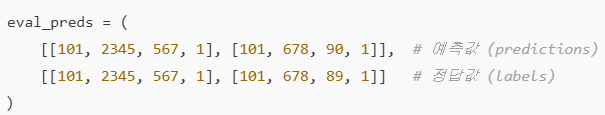

In [ ]:
import numpy as np

In [ ]:
def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]

    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    formatted_predictions = [{"id": ex['id'], "prediction_text": decoded_preds[i]} for i, ex in enumerate(datasets["validation"].select(range(max_val_samples)))]
    references = [{"id": ex["id"], "answers": ex["answers"]} for ex in datasets["validation"].select(range(max_val_samples))]

    result = metric.compute(predictions=formatted_predictions, references=references)
    return result

###**학습/검증/평가에 필요한 설정 정의**

In [ ]:
# 학습/평가에 필요한 설정 정의
args = Seq2SeqTrainingArguments(
    output_dir='outputs',  # 학습 결과와 모델 체크포인트가 저장될 디렉토리
    do_train=True,         # 학습을 수행할지 여부
    do_eval=True,          # 평가를 수행할지 여부
    predict_with_generate=True,  # 평가 시 생성된 텍스트를 사용할지 여부
    num_train_epochs=num_train_epochs,  # 학습할 에포크 수 (사용자가 미리 설정한 값)
    per_device_train_batch_size=8,  # 배치 사이즈 (예시 값, 필요에 따라 조정)
    per_device_eval_batch_size=8,   # 평가 배치 사이즈
)

#**6. 학습-> 검증-> 평가 (trainer)**

In [ ]:
from transformers import DataCollatorForSeq2Seq

# DataCollatorForSeq2Seq 설정 (토큰화, 패딩 처리)
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    label_pad_token_id=tokenizer.pad_token_id  # 패딩 토큰 설정
)

# Trainer 설정
trainer = Seq2SeqTrainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

In [ ]:
train_result = trainer.train(resume_from_checkpoint=None)  # 학습 실행 / 사이트에서 API 키 받아와서 입력하기

In [ ]:
print(train_result)

TrainOutput(global_step=750, training_loss=11.705498046875, metrics={'train_runtime': 202.2513, 'train_samples_per_second': 29.666, 'train_steps_per_second': 3.708, 'total_flos': 2169815235379200.0, 'train_loss': 11.705498046875, 'epoch': 3.0})


In [ ]:
## 평가하기
metrics = trainer.evaluate(
    max_length=max_target_length, num_beams=num_beams, metric_key_prefix="eval"
)

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

In [ ]:
print(metrics)

{'eval_loss': 6.962640285491943, 'eval_exact_match': 0.0, 'eval_f1': 1.1349206349206349, 'eval_runtime': 8.2673, 'eval_samples_per_second': 36.287, 'eval_steps_per_second': 4.596, 'epoch': 3.0}


**여기서 부터 문제가 발생한 것 같음**

## 7. **학습 시킨 model 적용해보기**

In [ ]:
# 질문과 문맥을 포함한 입력 생성
question = "최진실이 사망한 날짜는 언제인가?"
context = "- ↑ 유재순은 이 기사에서 \"애시당초 최진실은 조성민과 결혼하면 연기 생활을 줄이고 조성민이 1군에 올라 올 수 있도록 내조를 하겠다고 언론을 상대로 입에 침이 마르도록 떠들었다\"라고 하면서 '떠들었다'라는 표현을 썼는데, 이는 최진실에 대한 자신의 감정을 드러낸 셈이었다. 2002년부터 2004년에 걸쳐 3년 동안 최진실이 법에서 규정하고 있는 배우자로서의 의무를 위반했다는 증거가 나온 바 없었는데도 유재순은 최진실이 마치 유책배우자인 양 이런 표현을 썼던 것이다. 혼인신고의 전제는 상부상조다. 상부상조를 할 것이기 때문에 혼인을 하는 것이다. 이에 기혼 남성이 '외조를 잘하겠다'고 굳이 말할 필요 없고 기혼 여성이 '내조를 잘하겠다'고 굳이 말할 필요 없는 사안이다. 결혼을 앞둔 여성이 '내조를 잘하겠다'고 굳이 말했으면 그 결혼 상대 남성은 '그렇게 말까지 해주니 고맙다'가 되어야 상식적이다. 그런데 유재순은 그 말을 물고늘어지며 그 여성을 잡는 거리로 그 말을 악용하는 어처구니 없는 짓을 저지른 것이다. 더구나 그 여성은 전업주부도 아니고 별도의 직업을 가지고 있는 사람이었고 그것도 그 직업세계에서 매우 잘나가는 인물이었기 때문에 더더욱 고마워해야 하는 사안이었는데 유재순은 어찌된 영문인지 최진실을 후려치지 못해 안달하는 행태를 보였다. 유재순은 뭔가 크게 착각하고 있었다. 객관적으로 최진실은 능력으로든, 재력으로든, 인성으로든, 성격으로든, 외모로든, 남자가 아쉬운 입장이 아니었다. 최진실의 결혼 또한 조성민이 매달려서 이루어진 일이었다. 1998년 12월에 고등학생 때부터 최진실의 팬이었다며 조성민이 최진실에게 들러붙기 전까지는 조성민을 알지도 못했던 것이 최진실이었고, 1999년 2월에 7년 동안 최진실을 짝사랑했다며 성애적 관계를 원한다는 뜻을 최진실에게 표현한 쪽도 조성민이었다. 2002년부터 2004년까지 최진실에게 엉겨붙은 것도 조성민이었다. 2008년 10월 최진실의 사망 때까지 최진실을 대상으로 여론 조작을 하며 최진실에게 엉겨붙은 것도 조성민이었다. 최진실의 사망 후에도 최진실의 유가족에게 엉겨붙은 것도 조성민이었다. 다만 대한민국 사회 분위기가 이혼한 부모를 둔 아동에 대한 인권 침해가 심해 최진실에게는 그걸 염두에 둔 행보가 필요했을 뿐이었다. 최진실은 사회적, 경제적 지위에서 조성민보다 우위의 인물이었는데도 유재순은 '내조' 운운하며 평등 사상에 위배되는 행태를 보였던 것이고, 이는 기본적으로 조성민의 편에 선 자신의 포지션을 드러낸 것이었다. 2002년부터 2004년에 걸쳐 조성민이 최진실을 상대로 끊임없이 무리수를 두고 최진실을 고리로 노이즈 마케팅을 한 것은 최진실이 조성민보다 사회적, 경제적 지위가 우위임을 말해주는 반증이었다. 그리고 유재순은 마치 운동선수는 배우자로부터 반드시 수발을 받아야 하는 직업인 양 서술하였고, 최진실은 당연히 조성민의 수발을 들어야 하는데 그런 모습을 보이지 않아 불만이라는 듯 서술하였다. 유재순은 최진실이 마치 조성민의 수발이라도 들기 위해 결혼한 것처럼 최진실이 한 말을 따오며 조성민이 자신의 직업세계에서 무능한 모습을 보인 것이 최진실의 책임인 양 말하였다. 즉 최진실의 의례적인 성의 표시를 물고늘어지며 그런 행태를 보였던 것이다. 더구나 조성민이 자신의 직업세계에서 무능한 모습을 보인 것은 비혼자일 때도 보였던 바였고, 조성민은 자신의 수발을 들 사람이 필요하면 개인적으로 사람을 고용하면 될 일이었다. 요약을 하자면 유재순의 이런 비상식적인 행태는 2002년 12월 18일 오후 2시에 조성민이 기자회견을 통해 보인 행태와 대동소이했다는 것이다. 조성민은 최진실의 배우자가 되는 일을 추진하다가 그게 막히자 자살을 시도한 인물이었는데 자신의 수발을 들 사람을 얻기 위해 목숨을 건다는 것은 말이 되지 않았다. 더구나 조성민이 연예인 최진실을 굳이 자신의 수발을 들 사람으로 선택했다는 것도 말이 되지 않았다. 즉 유재순과 조성민의 행태는 여성은 남편의 수발을 들어야 한다는 비상식적 사회 분위기를 등에 엎고 최진실을 공격한 행태에 불과했다. 즉 조성민은 최진실의 수발을 들기는 커녕 최진실의 명예를 훼손하며 다녔다. 그리고 그 시간에 최진실은 2살의 아들과 태아인 딸을 양육하고 있었다. 다시 말하면 법에서 규정하고 있는 배우자로서의 의무를 위반한 것은 조성민이었고 유재순이 비난의 대상으로 삼아야 했던 것은 피해자 최진실이 아니라 가해자 조성민이었다. 하지만 유재순이나 조성민은 피해자 최진실을 비방하며 양비론의 프레임을 대중에게 주입시켰다. 유재순은 또 2002년 12월 18일 오후 2시에 조성민이 기자회견을 연 사건과 관련하여 '이혼 소동' 운운 하며 본질을 호도하였는데, 실체적 진실은 '이혼 소동'이 아니라 여론 조작 사건이었다. 애초에 최진실은 조성민으로부터 유책배우자라고 지칭된 상황에서 이혼할 의사가 없다고 하며 조성민에게 소송이혼 절차를 밟으라고 한 입장이었고, 조성민이 그런 기자회견을 열었다는 것은 합의이혼이 불발되었다는 반증이고 조성민은 가정법원에 가서 소송이혼 절차를 밟으면 되는 시간에 그런 황당한 기자회견을 열었던 것이다. 즉 이혼 문제는 소송이혼이라는 답이 나온 상황이었고 조성민은 가정법원을 통해 최진실이 유책배우자라는 주장을 입증하여 이혼 판결을 받으면 되었다. 이 기자회견에서 조성민은 최진실과 이혼이 하고 싶다고 했고 최진실이 유책배우자라고 주장했는데, 최진실은 2002년부터 2004년에 걸쳐 자신이 유책배우자라는 조성민의 여론 조작을 제압해 나갔다. 더불어 유재순의 여론 조작도 제압한 셈이었다. 더구나 최진실은 2002년 6월에도 여론 조작 사건을 겪은 바 있어 법적인 조치를 취한 바 있었고 2002년 12월의 여론 조작 사건은 그 내용의 심각성이 더 악질적인 것이어서 반드시 짚고 넘어가야 할 상황이었다. 무엇보다 그 여론 조작 행위자가 자기 자식들의 생부였기 때문에 반드시 그 진위를 공개적으로 규명해야 할 상황이었다."
document = f"질문: {question} 문맥: {context}"

# 입력 토큰화 및 디바이스 이동
input_ids = tokenizer.encode_plus(document, return_tensors='pt', truncation=True).input_ids
input_ids = input_ids.to(trainer.model.device)

# 모델 예측 생성
outputs = trainer.model.generate(
    input_ids,
    max_length=50,
    num_beams=4,
    early_stopping=True
)

# 출력 디코딩
decoded_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
print("Generated Answer:", decoded_output)

Generated Answer: <extra_id_0>


**최종 오류 : 학습 시킨 내용이 나오지 않음**